In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader


# Device configuration
device = torch.device('mps')



In [10]:

# Hyper-parameters 

num_classes = 1
num_epochs = 100
batch_size = 64
learning_rate = 0.001

"""

Each feature as a time step in your sequence, you could set sequence_length to 150 and input_size to 1.
This would mean you are feeding in sequences of length 150, with each time step in the sequence having 1 feature.

"""

input_size = 1 
sequence_length = 150 # the window it trains with can be selected
hidden_size = 128
num_layers = 2

In [11]:
# My dataset for gas sensor
df = pd.read_csv('../data/03_primary/model_input_table.csv')

# read data in 03primary model_inpput_table.pq
# df = pd.read_parquet('../data/03_primary/model_input_table.pq')

In [12]:
# Split data into features and target
X = df[df.columns[:-1]].values  # Assuming last column is the target
y = df[df.columns[-1]].values

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data
scaler.fit(X_train)

# Transform both training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure y_train and y_test are in the correct format
if isinstance(y_train, pd.Series):
    y_train = y_train.values
if isinstance(y_test, pd.Series):
    y_test = y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_test_tensor = torch.tensor(y_test.astype(np.float32))


In [14]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Initialize DataLoaders
batch_size = 64  # You can adjust the batch size according to your needs
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Now, train_loader and test_loader can be used in your training loop


In [15]:
# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        # out, _ = self.rnn(x, h0)  
        # or:
        out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


In [16]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (bins, target) in enumerate(train_loader):  
        bins = bins.reshape(-1, sequence_length, input_size).to(device)
        target = target.to(device)


        # Forward pass
        outputs = model(bins)
        target = target.unsqueeze(1).to(device)  # Add an extra dimension to match outputs
        loss = criterion(outputs, target)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    # Calculate RMSE at the end of each epoch
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Don't calculate gradients
        total_loss = 0
        count = 0
        for bins, target in test_loader:  # Replace with your validation loader
            bins = bins.reshape(-1, sequence_length, input_size).to(device)
            target = target.unsqueeze(1).to(device)  # Add an extra dimension to match outputs
            outputs = model(bins)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            count += 1
        rmse = np.sqrt(total_loss / count)
        print(f'Epoch [{epoch+1}/{num_epochs}], RMSE on validation data: {rmse}')
    model.train()  # Set the model back to training mode

Epoch [1/100], RMSE on validation data: 1.2877362451190881
Epoch [2/100], RMSE on validation data: 1.107381991520974
Epoch [3/100], RMSE on validation data: 0.6930309968707
Epoch [4/100], RMSE on validation data: 0.6370885278412256
Epoch [5/100], RMSE on validation data: 0.1840699695308559
Epoch [6/100], RMSE on validation data: 0.2520169613424524
Epoch [7/100], RMSE on validation data: 0.2970465114471489
Epoch [8/100], RMSE on validation data: 0.16977306404966203
Epoch [9/100], RMSE on validation data: 0.08086829988549077
Epoch [10/100], RMSE on validation data: 0.1826342712408054
Epoch [11/100], RMSE on validation data: 0.17276506360964952
Epoch [12/100], RMSE on validation data: 0.0953341543503998
Epoch [13/100], RMSE on validation data: 0.07280904805203206
Epoch [14/100], RMSE on validation data: 0.09581839178922964
Epoch [15/100], RMSE on validation data: 0.08731025767638463
Epoch [16/100], RMSE on validation data: 0.06805315230723259
Epoch [17/100], RMSE on validation data: 0.078

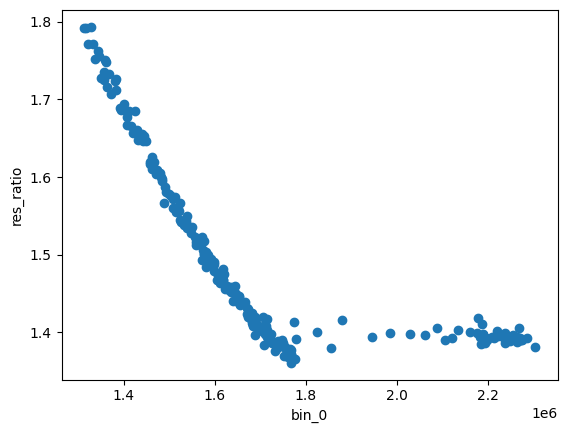

In [17]:
# plot bin_0 against res_ratio
plt.plot(df['bin_0'], df['res_ratio'], 'o')
plt.xlabel('bin_0')
plt.ylabel('res_ratio')
plt.show()